## **CNN para classificação (binária) multiclasse de imagens**
**Dataset Fashion-MNIST**
- Dataset de imagens de peças de vestuário
- Imagens de 28x28 pixeis
- 70k imagens das quais 60k são para treino e 10k para teste
- 10 classes e 785 atributos (o 1º é a classe a classificar o tipo de vestuário e as restantes são valores dos pixéis das imagens)
- Classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag e Ankle boot
    
Vamos utilizar uma rede neuronal para classificação do dígito em cada imagem de 28x28.

## imports

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
import torch.nn as nn
from torch.nn import BatchNorm2d
from torch.nn import Dropout2d
from torch.nn import Sequential
from torch.nn import Linear
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
 
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor
from torchvision.transforms import Normalize
from torchinfo import summary

import os
from livelossplot import PlotLosses

np.random.seed(0)
torch.manual_seed(0)
import random

random.seed(0)

torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(0)

torch.use_deterministic_algorithms(False) 

In [2]:
PATH = './'
PATH_TRAIN = '../AP_Aula3_PL_datasets/fashion-mnist_train.csv'
PATH_TEST = '../AP_Aula3_PL_datasets/fashion-mnist_test.csv'

BATCH_SIZE = 128

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(device)

cuda


## 1. Preparar os Dados

In [4]:
train_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,)) 
        ])
test_transform = Compose(
        [ToTensor(), 
         Normalize(mean=(0.1307,), std=(0.3081,))
        ])

In [5]:
class CSVDataset(Dataset):

    def __init__(self, path, transform=None):
        self.transform = transform

        df_set = pd.read_csv(path, header=0)

        self.x = df_set.values[:, 1:]
        self.y = df_set.values[:, 0]

        self.x = self.x.astype('float32')
        self.y = self.y.astype('long')
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 28, 28)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)
        x  = torch.from_numpy(np.array(x)).float()
        y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x,y)
        return cases 

def prepare_data_loaders(path_train, path_test):
    dataset_train = CSVDataset(path_train,transform=train_transform)
    dataset_test = CSVDataset(path_test,transform=test_transform)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test = dataset_test.get_TensorDataset()
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

## 1.1 Visualizar os Dados

In [6]:
def output_label(label):
    output_mapping = { 0: "T-shirt/Top", 1: "Trouser", 2: "Pullover",
                       3: "Dress",       4: "Coat",    5: "Sandal", 
                       6: "Shirt",       7: "Sneaker", 8: "Bag", 
                       9: "Ankle Boot" }
    output_mapping2 = { 0: "0", 1: "1", 2: "2", 3: "3", 4: "4", 
                       5: "5", 6: "6", 7: "7", 8: "8", 9: "9"}
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [7]:
from IPython.display import display

def visualize_data(path):
    df = pd.read_csv(path,header=0)
    display(df)

def visualize_dataset(train_dl, test_dl):
    print(f"Quantidade de casos de Treino:{len(train_dl.dataset)}") 
    print(f"Quantidade de casos de Validação:{len(val_dl.dataset)}")
    print(f"Quantidade de casos de Teste:{len(test_dl.dataset)}")
    
    x, y = next(iter(train_dl))
    print(f"Shape tensor batch casos treino, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(val_dl))
    print(f"Shape tensor batch casos validação, input: {x.shape}, output: {y.shape}")
    x, y = next(iter(test_dl))  
    print(f'Valor máximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')
    x=x.detach().numpy()
    print(f'Valor máximo:{np.max(x)} Valor mínimo:{np.min(x)}')
    print(y)

visualize_data(PATH_TRAIN)
visualize_dataset(train_dl, test_dl)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Quantidade de casos de Treino:48000
Quantidade de casos de Validação:12000
Quantidade de casos de Teste:10000
Shape tensor batch casos treino, input: torch.Size([128, 1, 28, 28]), output: torch.Size([128])
Shape tensor batch casos validação, input: torch.Size([128, 1, 28, 28]), output: torch.Size([128])
Valor máximo:1.0 Valor mínimo:0.0
Valor máximo:1.0 Valor mínimo:0.0
tensor([8, 8, 4, 0, 9, 7, 5, 2, 5, 4, 9, 8, 8, 8, 5, 3, 3, 2, 5, 3, 4, 0, 3, 2,
        3, 0, 0, 0, 2, 0, 9, 9, 2, 5, 7, 0, 7, 1, 8, 2, 2, 9, 9, 4, 3, 2, 3, 1,
        5, 3, 9, 0, 6, 9, 8, 3, 7, 4, 4, 2, 4, 3, 1, 6, 5, 5, 4, 9, 0, 1, 0, 4,
        7, 0, 6, 8, 3, 0, 2, 4, 3, 7, 5, 1, 8, 7, 3, 7, 0, 6, 1, 5, 1, 6, 9, 4,
        7, 4, 8, 7, 6, 4, 0, 1, 5, 8, 2, 1, 6, 2, 9, 8, 9, 1, 6, 9, 6, 6, 8, 5,
        3, 5, 2, 8, 1, 5, 1, 2])


torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])


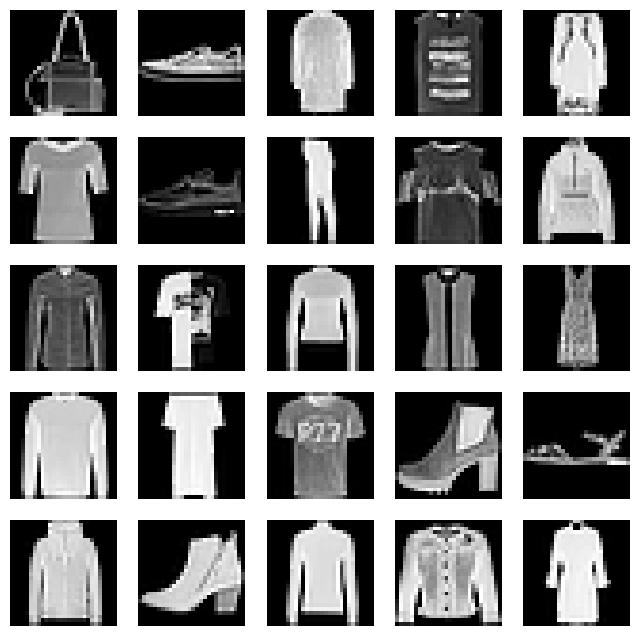

In [8]:
def visualize_images(dl):
    i, (inputs, targets) = next(enumerate(dl))
    print(inputs.shape)
    inputs = inputs.reshape(len(inputs), 1, 28, 28)
    print(inputs.shape)
    plt.figure(figsize=(8,8))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.grid()
        plt.imshow(inputs[i][0], cmap='gray')
    plt.show()

visualize_images(train_dl)

## 1.2 Verificar balanceamento do dataset

-----casos_treino------
casos: 48000
['Ankle Boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt/Top', 'Trouser']
[4814 4789 4733 4798 4816 4789 4835 4798 4787 4841]
48000


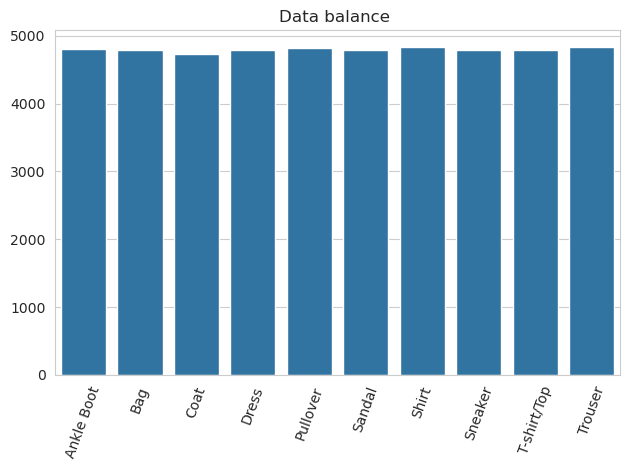

-----casos_validação------
casos: 12000
['Ankle Boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt/Top', 'Trouser']
[1186 1211 1267 1202 1184 1211 1165 1202 1213 1159]
12000


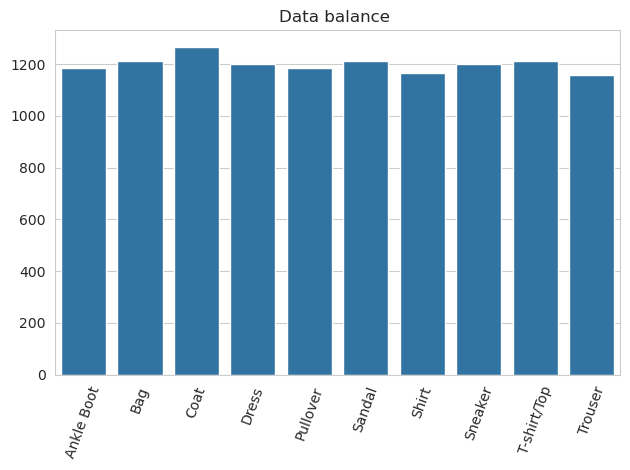

-----casos_teste------
casos: 10000
['Ankle Boot', 'Bag', 'Coat', 'Dress', 'Pullover', 'Sandal', 'Shirt', 'Sneaker', 'T-shirt/Top', 'Trouser']
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
10000


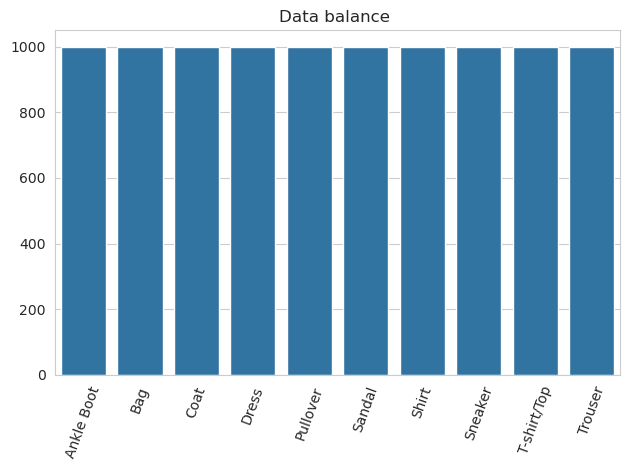

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_holdout_balance(dl):
    _, labels = next(iter(dl)) 
    output_mapping = { 0: "T-shirt/Top", 1: "Trouser", 2: "Pullover",
                       3: "Dress",       4: "Coat",    5: "Sandal", 
                       6: "Shirt",       7: "Sneaker", 8: "Bag", 
                       9: "Ankle Boot" }
    sns.set_style('whitegrid')
    print("casos:",len(labels))
    label_names = [output_mapping[label.item()] for label in labels]
    x, y = np.unique(label_names, return_counts=True)
    x=[str(n) for n in x]
    print(x)
    print(y)
    print(np.sum(y))
    grafico=sns.barplot(x=x, y=y)
    grafico.set_title('Data balance ')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show() 

print("-----casos_treino------")   
visualize_holdout_balance(train_dl_all)
print("-----casos_validação------")   
visualize_holdout_balance(val_dl_all)
print("-----casos_teste------") 
visualize_holdout_balance(test_dl_all)

## 2. Definir o Modelo

In [10]:
class CNNModel_1(Module):
    def __init__(self):
        super(CNNModel_1, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.layer2 = Sequential(Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3)),
                                 ReLU(),
                                 MaxPool2d(kernel_size=(2,2), stride=(2,2))           
                                )
        self.fc1 = Linear(in_features=5*5*32, out_features=100)
        kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        self.fc2 = Linear(in_features=100, out_features=10)
        xavier_uniform_(self.fc2.weight)
        self.act2 = Softmax(dim=1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 5*5*32)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out) 
        out = self.act2(out)
        return out

model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 13, 13]         --
│    └─Conv2d: 2-1                       [128, 32, 26, 26]         320
│    └─ReLU: 2-2                         [128, 32, 26, 26]         --
│    └─MaxPool2d: 2-3                    [128, 32, 13, 13]         --
├─Sequential: 1-2                        [128, 32, 5, 5]           --
│    └─Conv2d: 2-4                       [128, 32, 11, 11]         9,248
│    └─ReLU: 2-5                         [128, 32, 11, 11]         --
│    └─MaxPool2d: 2-6                    [128, 32, 5, 5]           --
├─Linear: 1-3                            [128, 100]                80,100
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
├─Softmax: 1-6                           [128, 10]                 --
Tota

CNNModel_1(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act2): Softmax(dim=1)
)

In [11]:
class CNNModel_2(Module):
    def __init__(self):
        super(CNNModel_2, self).__init__()
        self.layer1 = Sequential(Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )
        self.layer2 = Sequential(Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0),
                                 ReLU(),
                                 MaxPool2d(kernel_size=2)
                                )       
        self.fc1 = Linear(32 * 5 * 5, 10)  
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        return out
    
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [128, 10]                 --
├─Sequential: 1-1                        [128, 16, 13, 13]         --
│    └─Conv2d: 2-1                       [128, 16, 26, 26]         160
│    └─ReLU: 2-2                         [128, 16, 26, 26]         --
│    └─MaxPool2d: 2-3                    [128, 16, 13, 13]         --
├─Sequential: 1-2                        [128, 32, 5, 5]           --
│    └─Conv2d: 2-4                       [128, 32, 11, 11]         4,640
│    └─ReLU: 2-5                         [128, 32, 11, 11]         --
│    └─MaxPool2d: 2-6                    [128, 32, 5, 5]           --
├─Linear: 1-3                            [128, 10]                 8,010
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
Total mult-adds (M): 86.73
Input size (MB): 0.40
Forward/backward pass size (MB): 15.05
Params size (MB): 0.05
Estimated Total Size (MB): 15.50


CNNModel_2(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=800, out_features=10, bias=True)
)

In [12]:
class CNNModel_3(Module):
    def __init__(self):
        super(CNNModel_3, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = Linear(in_features=600, out_features=120)
        self.fc3 = Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         320
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-4                    [128, 32, 14, 14]         --
├─Sequential: 1-2                        [128, 64, 6, 6]           --
│    └─Conv2d: 2-5                       [128, 64, 12, 12]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 12, 12]         128
│    └─ReLU: 2-7                         [128, 64, 12, 12]         --
│    └─MaxPool2d: 2-8                    [128, 64, 6, 6]           --
├─Linear: 1-3                            [128, 600]                1,383,000
├─Dropout2d: 1-4                         [128, 600]                --
├─

/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


CNNModel_3(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)

In [13]:
class CNNModel_4(Module):
    def __init__(self):
        super(CNNModel_4, self).__init__()
        self.layer1 = Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=0),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(2),
                                    Dropout2d(0.2)
                                    )
        self.fc1 = Linear(in_features=32*12*12, out_features=128)
        self.fc2 = Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    

model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 12, 12]         --
│    └─Conv2d: 2-1                       [128, 32, 24, 24]         832
│    └─BatchNorm2d: 2-2                  [128, 32, 24, 24]         64
│    └─ReLU: 2-3                         [128, 32, 24, 24]         --
│    └─MaxPool2d: 2-4                    [128, 32, 12, 12]         --
│    └─Dropout2d: 2-5                    [128, 32, 12, 12]         --
├─Linear: 1-2                            [128, 128]                589,952
├─Linear: 1-3                            [128, 10]                 1,290
Total params: 592,138
Trainable params: 592,138
Non-trainable params: 0
Total mult-adds (M): 137.03
Input size (MB): 0.40
Forward/backward pass size (MB): 37.89
Params size (MB): 2.37
Estimated Total Size (MB): 40.66


CNNModel_4(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

## 3. Treinar o Modelo

In [14]:
def train_model(h5_file, train_dl, val_dl, model, criterion, optimizer):
    liveloss = PlotLosses()
    for epoch in range(EPOCHS):
        logs = {}
        model.train() 
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in train_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_corrects.float() / len(train_dl.dataset)
        logs['loss'] = epoch_loss.item()
        logs['accuracy'] = epoch_acc.item()
        model.eval()
        running_loss  = 0.0
        running_corrects  = 0.0
        for inputs, labels in val_dl: 
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.detach() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(val_dl.dataset)
        epoch_acc = running_corrects.float() / len(val_dl.dataset)
        logs['val_loss'] = epoch_loss.item()
        logs['val_accuracy'] = epoch_acc.item()
        liveloss.update(logs)
        liveloss.send()
    torch.save(model,h5_file)

In [15]:
######### CNNModel_1 ################
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_1                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 13, 13]         --
│    └─Conv2d: 2-1                       [128, 32, 26, 26]         320
│    └─ReLU: 2-2                         [128, 32, 26, 26]         --
│    └─MaxPool2d: 2-3                    [128, 32, 13, 13]         --
├─Sequential: 1-2                        [128, 32, 5, 5]           --
│    └─Conv2d: 2-4                       [128, 32, 11, 11]         9,248
│    └─ReLU: 2-5                         [128, 32, 11, 11]         --
│    └─MaxPool2d: 2-6                    [128, 32, 5, 5]           --
├─Linear: 1-3                            [128, 100]                80,100
├─ReLU: 1-4                              [128, 100]                --
├─Linear: 1-5                            [128, 10]                 1,010
├─Softmax: 1-6                           [128, 10]                 --
Tota

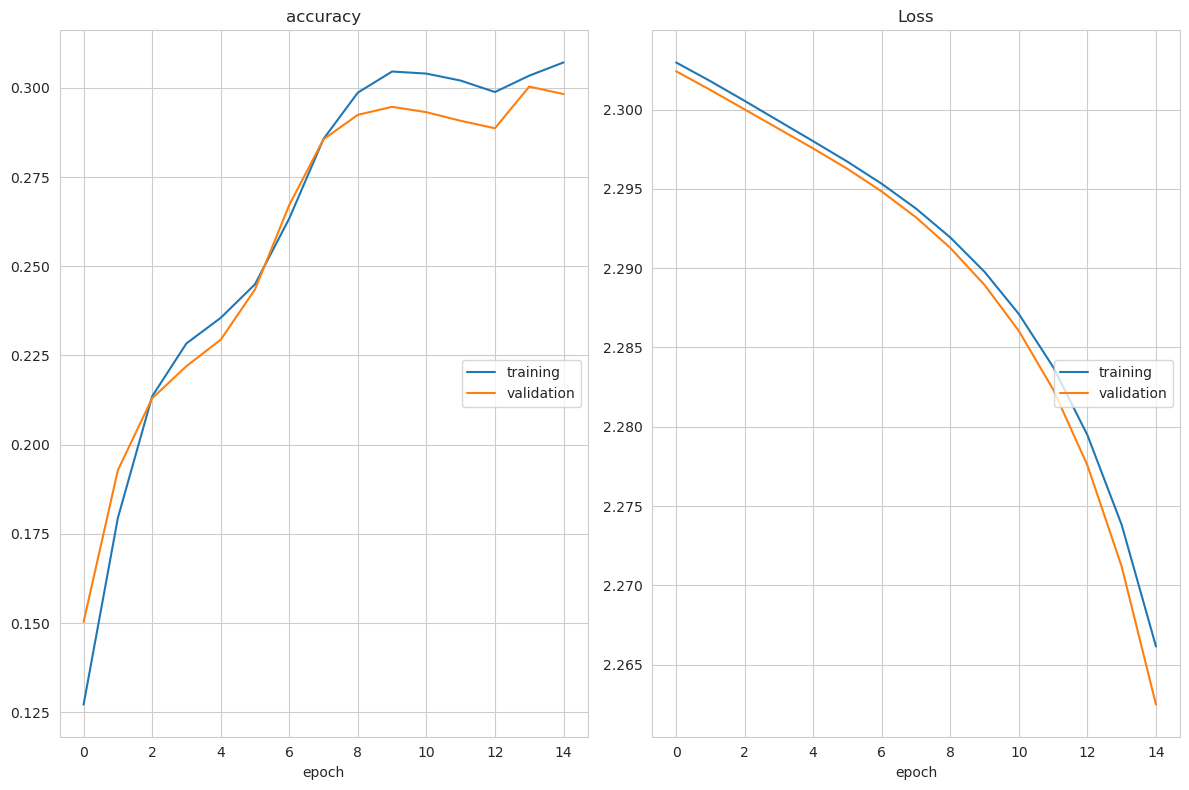

accuracy
	training         	 (min:    0.127, max:    0.307, cur:    0.307)
	validation       	 (min:    0.150, max:    0.300, cur:    0.298)
Loss
	training         	 (min:    2.266, max:    2.303, cur:    2.266)
	validation       	 (min:    2.262, max:    2.302, cur:    2.262)
Tempo gasto: 21.554050194999945 segundos


In [16]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_fashion_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [17]:
######### CNNModel_2 ################
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_2                               [128, 10]                 --
├─Sequential: 1-1                        [128, 16, 13, 13]         --
│    └─Conv2d: 2-1                       [128, 16, 26, 26]         160
│    └─ReLU: 2-2                         [128, 16, 26, 26]         --
│    └─MaxPool2d: 2-3                    [128, 16, 13, 13]         --
├─Sequential: 1-2                        [128, 32, 5, 5]           --
│    └─Conv2d: 2-4                       [128, 32, 11, 11]         4,640
│    └─ReLU: 2-5                         [128, 32, 11, 11]         --
│    └─MaxPool2d: 2-6                    [128, 32, 5, 5]           --
├─Linear: 1-3                            [128, 10]                 8,010
Total params: 12,810
Trainable params: 12,810
Non-trainable params: 0
Total mult-adds (M): 86.73
Input size (MB): 0.40
Forward/backward pass size (MB): 15.05
Params size (MB): 0.05
Estimated Total Size (MB): 15.50


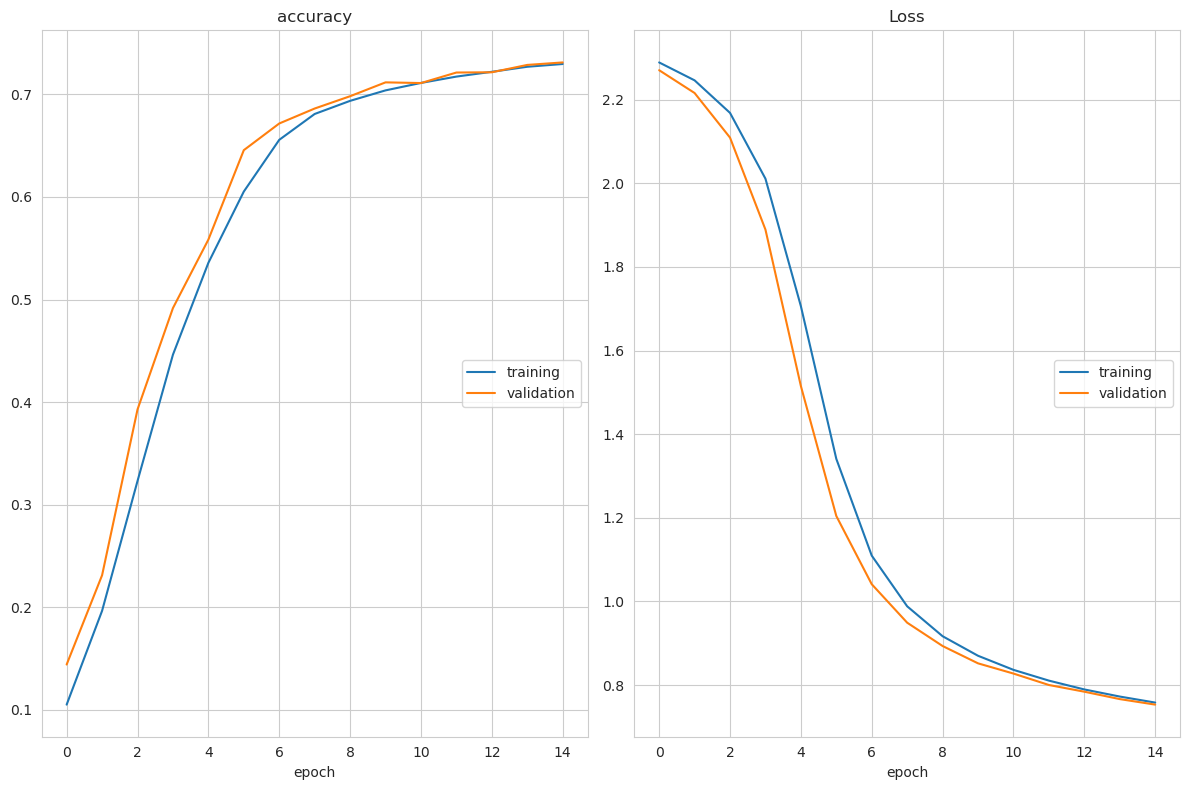

accuracy
	training         	 (min:    0.105, max:    0.730, cur:    0.730)
	validation       	 (min:    0.144, max:    0.731, cur:    0.731)
Loss
	training         	 (min:    0.758, max:    2.289, cur:    0.758)
	validation       	 (min:    0.753, max:    2.271, cur:    0.753)
Tempo gasto: 19.997894692000045 segundos


In [18]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_fashion_2.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [19]:
######### CNNModel_3 ################
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_3                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         320
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-4                    [128, 32, 14, 14]         --
├─Sequential: 1-2                        [128, 64, 6, 6]           --
│    └─Conv2d: 2-5                       [128, 64, 12, 12]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 12, 12]         128
│    └─ReLU: 2-7                         [128, 64, 12, 12]         --
│    └─MaxPool2d: 2-8                    [128, 64, 6, 6]           --
├─Linear: 1-3                            [128, 600]                1,383,000
├─Dropout2d: 1-4                         [128, 600]                --
├─

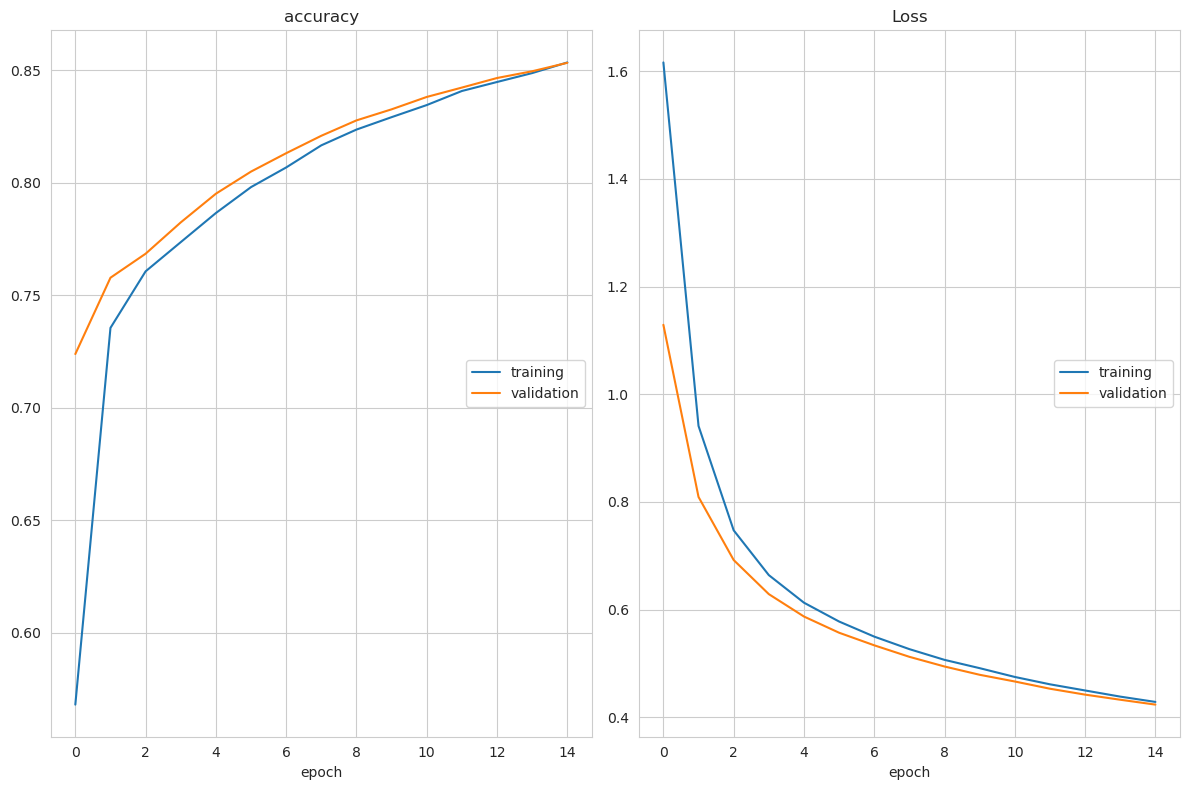

accuracy
	training         	 (min:    0.568, max:    0.853, cur:    0.853)
	validation       	 (min:    0.724, max:    0.853, cur:    0.853)
Loss
	training         	 (min:    0.428, max:    1.616, cur:    0.428)
	validation       	 (min:    0.423, max:    1.129, cur:    0.423)
Tempo gasto: 32.571905832000084 segundos


In [20]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_fashion_3.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [21]:
######### CNNModel_4 ################
model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel_4                               [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 12, 12]         --
│    └─Conv2d: 2-1                       [128, 32, 24, 24]         832
│    └─BatchNorm2d: 2-2                  [128, 32, 24, 24]         64
│    └─ReLU: 2-3                         [128, 32, 24, 24]         --
│    └─MaxPool2d: 2-4                    [128, 32, 12, 12]         --
│    └─Dropout2d: 2-5                    [128, 32, 12, 12]         --
├─Linear: 1-2                            [128, 128]                589,952
├─Linear: 1-3                            [128, 10]                 1,290
Total params: 592,138
Trainable params: 592,138
Non-trainable params: 0
Total mult-adds (M): 137.03
Input size (MB): 0.40
Forward/backward pass size (MB): 37.89
Params size (MB): 2.37
Estimated Total Size (MB): 40.66


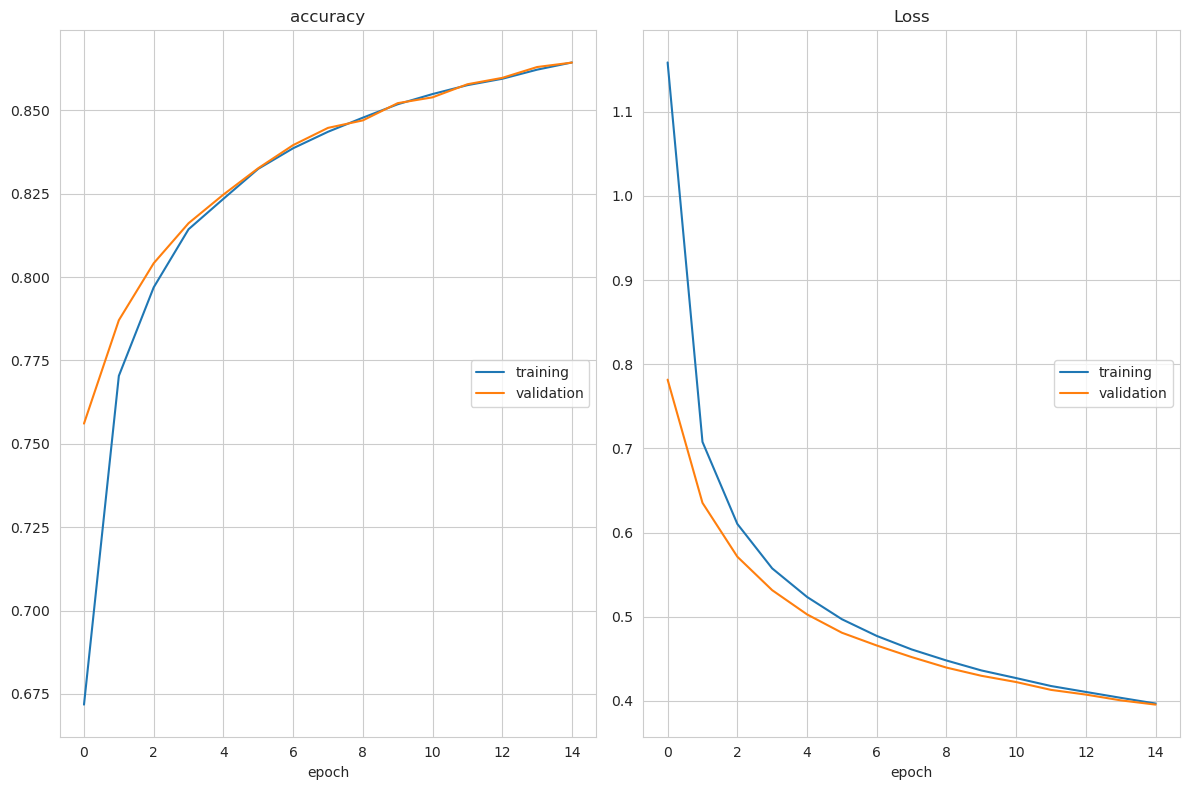

accuracy
	training         	 (min:    0.672, max:    0.864, cur:    0.864)
	validation       	 (min:    0.756, max:    0.864, cur:    0.864)
Loss
	training         	 (min:    0.397, max:    1.159, cur:    0.397)
	validation       	 (min:    0.396, max:    0.782, cur:    0.396)
Tempo gasto: 20.923963073000778 segundos


In [22]:
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_fashion_4.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

## 4. Avaliar o Modelo

In [24]:
def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    for inputs, labels in test_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        yprev = model(inputs)
        yprev = yprev.detach().cpu().numpy()
        actual = labels.cpu().numpy()
        yprev = np.argmax(yprev, axis=1)
        actual = actual.reshape((len(actual), 1))
        yprev = yprev.reshape((len(yprev), 1))
        predictions.append(yprev)
        actual_values.append(actual)
        #break
    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions ):
    acertou=0
    falhou = 0
    primeiros=0
    for r,p in zip(actual_values, predictions):
        if primeiros <20:
            print(f'real:{r} previsão:{p}') 
            primeiros +=1
        if r==p: acertou+=1  
        else: falhou+=1

    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(test_dl.dataset)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou:{acertou} falhou:{falhou}')

def display_confusion_matrix(cm,list_classes):
    plt.figure(figsize = (16,8))
    sns.heatmap(cm,annot=True,xticklabels=list_classes,yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

    
actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions )
print(classification_report(actual_values, predictions))
cr =classification_report(actual_values, predictions, output_dict=True)
list_classes=list(cr.keys())[0:10]
cm = confusion_matrix(actual_values, predictions)

print (cm)
display_confusion_matrix(cm,list_classes)

OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB. GPU 0 has a total capacity of 3.80 GiB of which 1.56 MiB is free. Process 15959 has 110.00 MiB memory in use. Process 16980 has 2.06 GiB memory in use. Including non-PyTorch memory, this process has 1.57 GiB memory in use. Of the allocated memory 1.45 GiB is allocated by PyTorch, and 24.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

---------------------------------------------------------------------------
OutOfMemoryError                          Traceback (most recent call last)
Cell In[23], line 48
     44     plt.xlabel('Predicted label')
     45     plt.show() 
---> 48 actual_values, predictions = evaluate_model(test_dl_all, model)
     49 display_predictions(actual_values, predictions )
     50 print(classification_report(actual_values, predictions))

Cell In[23], line 7
      5 inputs = inputs.to(device)
      6 labels = labels.to(device)
----> 7 yprev = model(inputs)
      8 yprev = yprev.detach().cpu().numpy()
      9 actual = labels.cpu().numpy()

File ~/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py:1739, in Module._wrapped_call_impl(self, *args, **kwargs)
   1737     return self._compiled_call_impl(*args, **kwargs)  # type: ignore[misc]
   1738 else:
-> 1739     return self._call_impl(*args, **kwargs)

File ~/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/modules/module.py:1750, in Module._call_impl(self, *args, **kwargs)
   1745 # If we don't have any hooks, we want to skip the rest of the logic in
   1746 # this function, and just call forward.
   1747 if not (self._backward_hooks or self._backward_pre_hooks or self._forward_hooks or self._forward_pre_hooks
...
   1703 else:
-> 1704     result = torch.relu(input)
   1705 return result

OutOfMemoryError: CUDA out of memory. Tried to allocate 704.00 MiB. GPU 0 has a total capacity of 3.80 GiB of which 1.56 MiB is free. Process 15959 has 110.00 MiB memory in use. Process 16980 has 2.06 GiB memory in use. Including non-PyTorch memory, this process has 1.57 GiB memory in use. Of the allocated memory 1.45 GiB is allocated by PyTorch, and 24.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...

In [29]:
BATCH_SIZE = 8

real:[0] previsão:[0]
real:[1] previsão:[1]
real:[2] previsão:[2]
real:[2] previsão:[6]
real:[3] previsão:[3]
real:[2] previsão:[6]
real:[8] previsão:[8]
real:[6] previsão:[6]
real:[5] previsão:[5]
real:[0] previsão:[0]
real:[3] previsão:[3]
real:[4] previsão:[4]
real:[4] previsão:[4]
real:[6] previsão:[6]
real:[8] previsão:[8]
real:[5] previsão:[5]
real:[6] previsão:[6]
real:[3] previsão:[3]
real:[6] previsão:[6]
real:[4] previsão:[4]
Accuracy: 0.870

acertou: 8698 falhou: 1302
              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1000
           1       0.98      0.96      0.97      1000
           2       0.82      0.81      0.81      1000
           3       0.88      0.90      0.89      1000
           4       0.82      0.81      0.82      1000
           5       0.94      0.93      0.94      1000
           6       0.66      0.64      0.65      1000
           7       0.90      0.90      0.90      1000
           8       0.95      

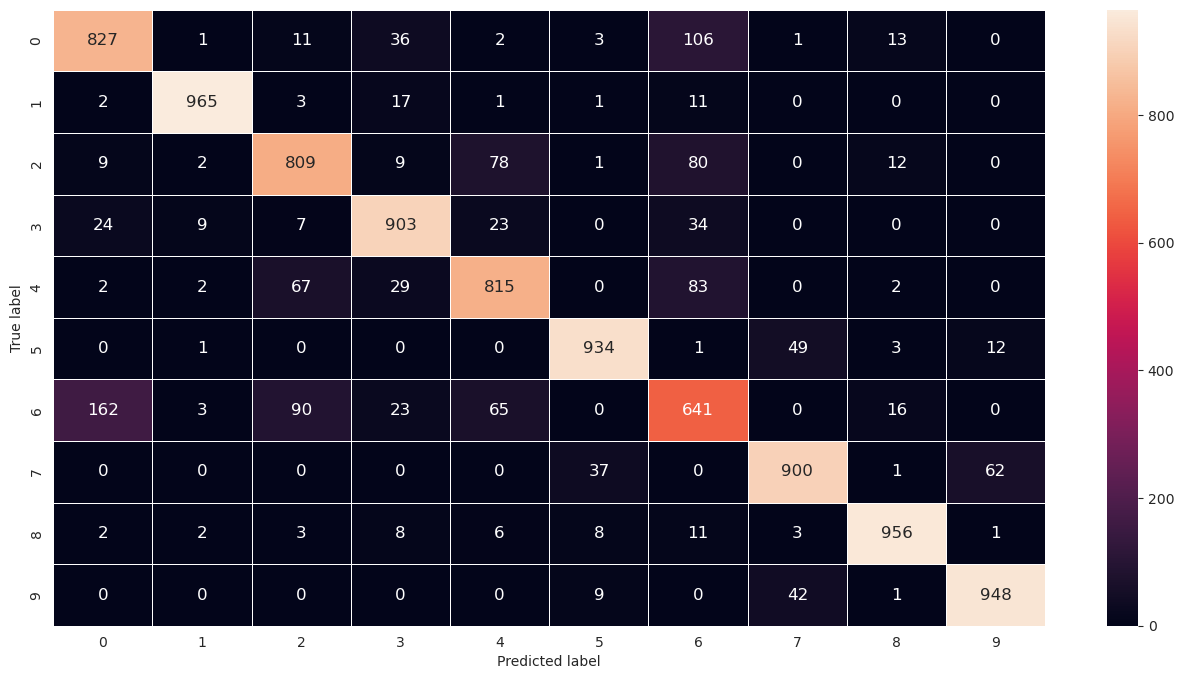

In [ ]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    with torch.no_grad():  
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            yprev = model(inputs)

            yprev = yprev.detach().cpu().numpy()
            actual = labels.cpu().numpy()

            yprev = np.argmax(yprev, axis=1)
            actual = actual.reshape((len(actual), 1))
            yprev = yprev.reshape((len(yprev), 1))

            predictions.append(yprev)
            actual_values.append(actual)
            
            # Clear GPU memory to avoid fragmentation
            torch.cuda.empty_cache()

    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions):
    acertou = 0
    falhou = 0
    primeiros = 0
    for r, p in zip(actual_values, predictions):
        if primeiros < 20:
            print(f'real:{r} previsão:{p}') 
            primeiros += 1
        if r == p:
            acertou += 1  
        else:
            falhou += 1

    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(actual_values)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou: {acertou} falhou: {falhou}')

def display_confusion_matrix(cm, list_classes):
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, xticklabels=list_classes, yticklabels=list_classes, annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show() 

actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions)
print(classification_report(actual_values, predictions))

cr = classification_report(actual_values, predictions, output_dict=True)
list_classes = list(cr.keys())[:10]
cm = confusion_matrix(actual_values, predictions)

print(cm)
display_confusion_matrix(cm, list_classes)


## 5. Usar o Modelo

torch.Size([1, 1, 28, 28])
torch.float32
predict: Coat


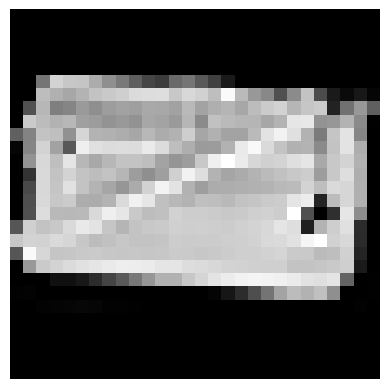

In [32]:
def make_prediction(model, img):
    img = img.reshape(1, 1, 28, 28)
    print(img.shape)
    print(img.dtype)
    img = img.to(device) #valves
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    output_mapping = { 0: "T-shirt/Top", 1: "Trouser", 2: "Pullover",
                       3: "Dress",       4: "Coat",    5: "Sandal", 
                       6: "Shirt",       7: "Sneaker", 8: "Bag", 
                       9: "Ankle Boot" }
    print("predict:",output_mapping[prediction])
    img=img.cpu()
    plt.axis('off')
    plt.grid()
    plt.imshow(img[0,0], cmap=plt.get_cmap('gray'))
    plt.show()
    
model= torch.load('CNNModel_fashion_1.pth',weights_only=False)
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3])

## T4 - Modelo "MY_CNN" para a ficha Ficha_CNN_fashion_mnist 

In [33]:
class CSVDataset(Dataset):

    def __init__(self, path, transform=None):
        self.transform = transform

        df_set = pd.read_csv(path, header=0)

        self.x = df_set.values[:, 1:]
        self.y = df_set.values[:, 0]

        self.x = self.x.astype('float32')
        self.y = self.y.astype('long')
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 28, 28)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)
        x  = torch.from_numpy(np.array(x)).float()
        y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x,y)
        return cases 

def prepare_data_loaders(path_train, path_test):
    dataset_train = CSVDataset(path_train,transform=train_transform)
    dataset_test = CSVDataset(path_test,transform=test_transform)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test = dataset_test.get_TensorDataset()
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)  

In [34]:
BATCH_SIZE = 128
class MY_CNN(Module):
    def __init__(self):
        super(MY_CNN, self).__init__()
        self.layer1 = nn.Sequential(Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
                                    BatchNorm2d(32),
                                    ReLU(),
                                    MaxPool2d(kernel_size=2, stride=2)
                                    )
        self.layer2 = nn.Sequential(Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                    BatchNorm2d(64),
                                    ReLU(),
                                    MaxPool2d(2)
                                    )
        self.fc1 = Linear(in_features=64*6*6, out_features=1024)
        self.drop1 = nn.Dropout2d(0.3)
        self.fc2 = Linear(in_features=1024, out_features=516)
        self.fc3 = Linear(in_features=516, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out
    
model = MY_CNN()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
model.to(device)

Layer (type:depth-idx)                   Output Shape              Param #
MY_CNN                                   [128, 10]                 --
├─Sequential: 1-1                        [128, 32, 14, 14]         --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         320
│    └─BatchNorm2d: 2-2                  [128, 32, 28, 28]         64
│    └─ReLU: 2-3                         [128, 32, 28, 28]         --
│    └─MaxPool2d: 2-4                    [128, 32, 14, 14]         --
├─Sequential: 1-2                        [128, 64, 6, 6]           --
│    └─Conv2d: 2-5                       [128, 64, 12, 12]         18,496
│    └─BatchNorm2d: 2-6                  [128, 64, 12, 12]         128
│    └─ReLU: 2-7                         [128, 64, 12, 12]         --
│    └─MaxPool2d: 2-8                    [128, 64, 6, 6]           --
├─Linear: 1-3                            [128, 1024]               2,360,320
├─Dropout2d: 1-4                         [128, 1024]               --
├─

/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


MY_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=1024, bias=True)
  (drop1): Dropout2d(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=516, bias=True)
  (fc3): Linear(in_features=516, out_features=10, bias=True)
)

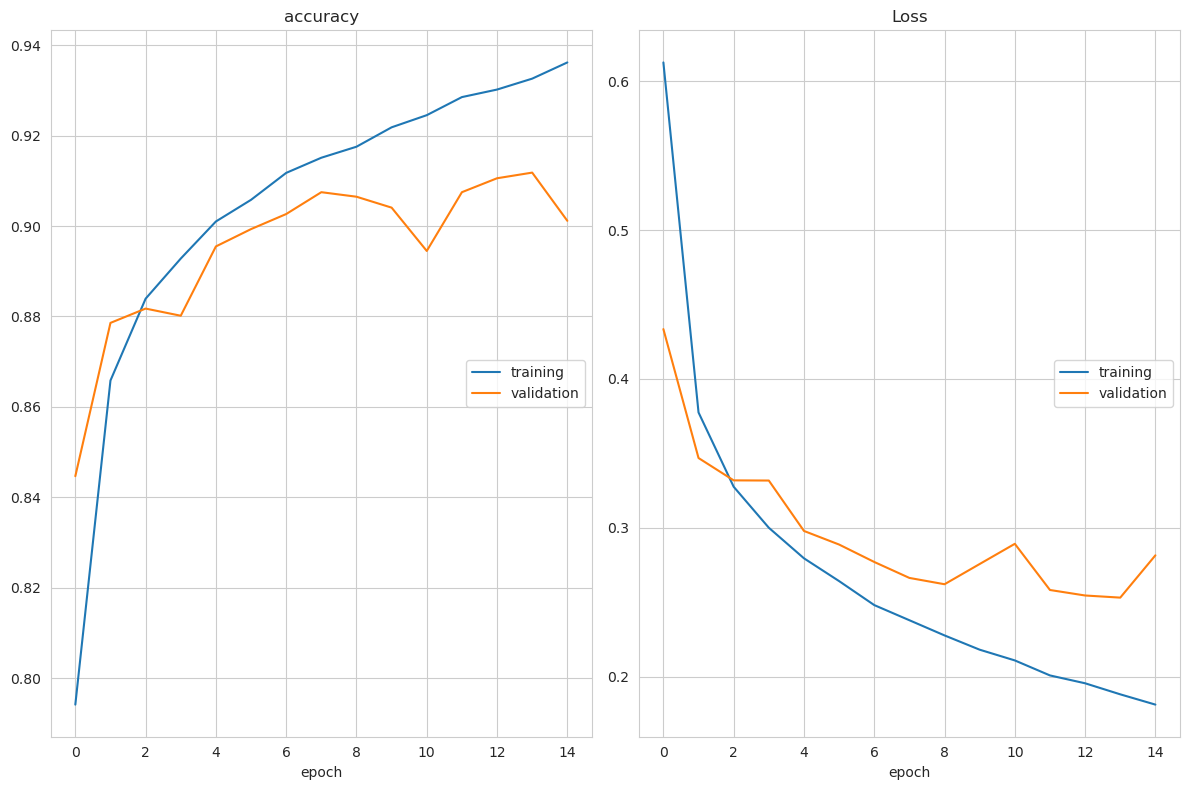

accuracy
	training         	 (min:    0.794, max:    0.936, cur:    0.936)
	validation       	 (min:    0.845, max:    0.912, cur:    0.901)
Loss
	training         	 (min:    0.181, max:    0.613, cur:    0.181)
	validation       	 (min:    0.253, max:    0.433, cur:    0.282)
Tempo gasto: 170.17940024000018 segundos


In [36]:
######### MY_CNN ##########
model = MY_CNN()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
EPOCHS = 15
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('MY_CNN_fashion.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

In [49]:
BATCH_SIZE = 8

In [51]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_model(test_dl, model):
    predictions = list()
    actual_values = list()
    with torch.no_grad():  
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            yprev = model(inputs)
            
            yprev = yprev.detach().cpu().numpy()
            actual = labels.cpu().numpy()
            
            yprev = np.argmax(yprev, axis=1)
            actual = actual.reshape((len(actual), 1))
            yprev = yprev.reshape((len(yprev), 1))

            predictions.append(yprev)
            actual_values.append(actual)

            torch.cuda.empty_cache()

    predictions, actual_values = np.vstack(predictions), np.vstack(actual_values)
    return actual_values, predictions

def display_predictions(actual_values, predictions):
    acertou = 0
    falhou = 0
    primeiros = 0
    for r, p in zip(actual_values, predictions):
        if primeiros < 20:
            print(f'real:{r} previsão:{p}')
            primeiros += 1
        if r == p:
            acertou += 1  
        else:
            falhou += 1

    corrects = np.sum(predictions == actual_values)
    acc = corrects / len(actual_values)
    acc = accuracy_score(actual_values, predictions)
    print(f'Accuracy: {acc:0.3f}\n')
    print(f'acertou: {acertou} falhou: {falhou}')

def display_confusion_matrix(cm, list_classes):
    plt.figure(figsize=(16, 8))
    sns.heatmap(cm, annot=True, xticklabels=list_classes, yticklabels=list_classes,
                annot_kws={"size": 12}, fmt='g', linewidths=.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


actual_values, predictions = evaluate_model(test_dl_all, model)
display_predictions(actual_values, predictions)
print(classification_report(actual_values, predictions))

cr = classification_report(actual_values, predictions, output_dict=True)
list_classes = list(cr.keys())[:10]
cm = confusion_matrix(actual_values, predictions)

print(cm)
display_confusion_matrix(cm, list_classes)


OutOfMemoryError: CUDA out of memory. Tried to allocate 958.00 MiB. GPU 0 has a total capacity of 3.80 GiB of which 311.56 MiB is free. Process 15959 has 110.00 MiB memory in use. Process 16980 has 2.06 GiB memory in use. Including non-PyTorch memory, this process has 1.27 GiB memory in use. Of the allocated memory 1.13 GiB is allocated by PyTorch, and 39.91 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

torch.Size([1, 1, 28, 28])
torch.float32
predict: Coat


/home/eduardo/miniconda3/envs/env/lib/python3.10/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


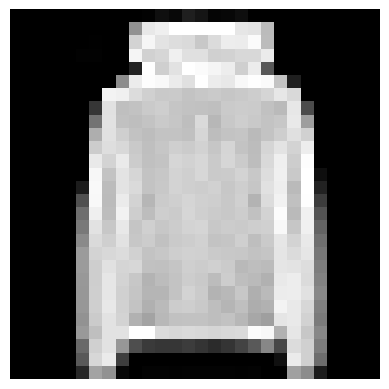

In [52]:
def make_prediction(model, img):
    img = img.reshape(1, 1, 28, 28)
    print(img.shape)
    print(img.dtype)
    img = img.to(device) #valves
    prediction = model(img).cpu().detach().numpy()[0].argmax()
    output_mapping = { 0: "T-shirt/Top", 1: "Trouser", 2: "Pullover",
                       3: "Dress",       4: "Coat",    5: "Sandal", 
                       6: "Shirt",       7: "Sneaker", 8: "Bag", 
                       9: "Ankle Boot" }
    print("predict:",output_mapping[prediction])
    img=img.cpu()
    plt.axis('off')
    plt.grid()
    plt.imshow(img[0,0], cmap=plt.get_cmap('gray'))
    plt.show()
    
model= torch.load('MY_CNN_fashion.pth',weights_only=False)
imagens, label = next(iter(test_dl))
make_prediction(model,imagens[3])

## T5 - Registar os valores de desempenho dos modelos sem o passo de normalização dos dados 

In [53]:
class CSVDataset(Dataset):

    def __init__(self, path, transform=None):
        self.transform = transform

        df_set = pd.read_csv(path, header=0)

        self.x = df_set.values[:, 1:]
        self.y = df_set.values[:, 0]

        self.x = self.x.astype('float32')
        self.y = self.y.astype('long')
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        label = self.y[idx]
        image = self.x[idx]       
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
    def get_TensorDataset(self):
        x = self.x.reshape(len(self.x), 1, 28, 28)
        xmax, xmin = x.max(), x.min()
        x = (x - xmin)/(xmax - xmin)
        x  = torch.from_numpy(np.array(x)).float()
        y  = torch.from_numpy(np.array(self.y)).type(torch.LongTensor)
        cases = torch.utils.data.TensorDataset(x,y)
        return cases 

def prepare_data_loaders(path_train, path_test):
    dataset_train = CSVDataset(path_train)
    dataset_test = CSVDataset(path_test)
    train = dataset_train.get_TensorDataset()
    train_size = int(0.8 * len(train))
    val_size = len(train) - train_size
    train, validation = random_split(train, [train_size, val_size], generator=torch.Generator().manual_seed(42))
    test = dataset_test.get_TensorDataset()
    
    train_dl = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
    train_dl_all = DataLoader(train, batch_size=len(train), shuffle=False)
    val_dl_all = DataLoader(validation, batch_size=len(validation), shuffle=True)
    test_dl_all = DataLoader(test, batch_size=len(test), shuffle=False)
    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all

train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = prepare_data_loaders(PATH_TRAIN, PATH_TEST)

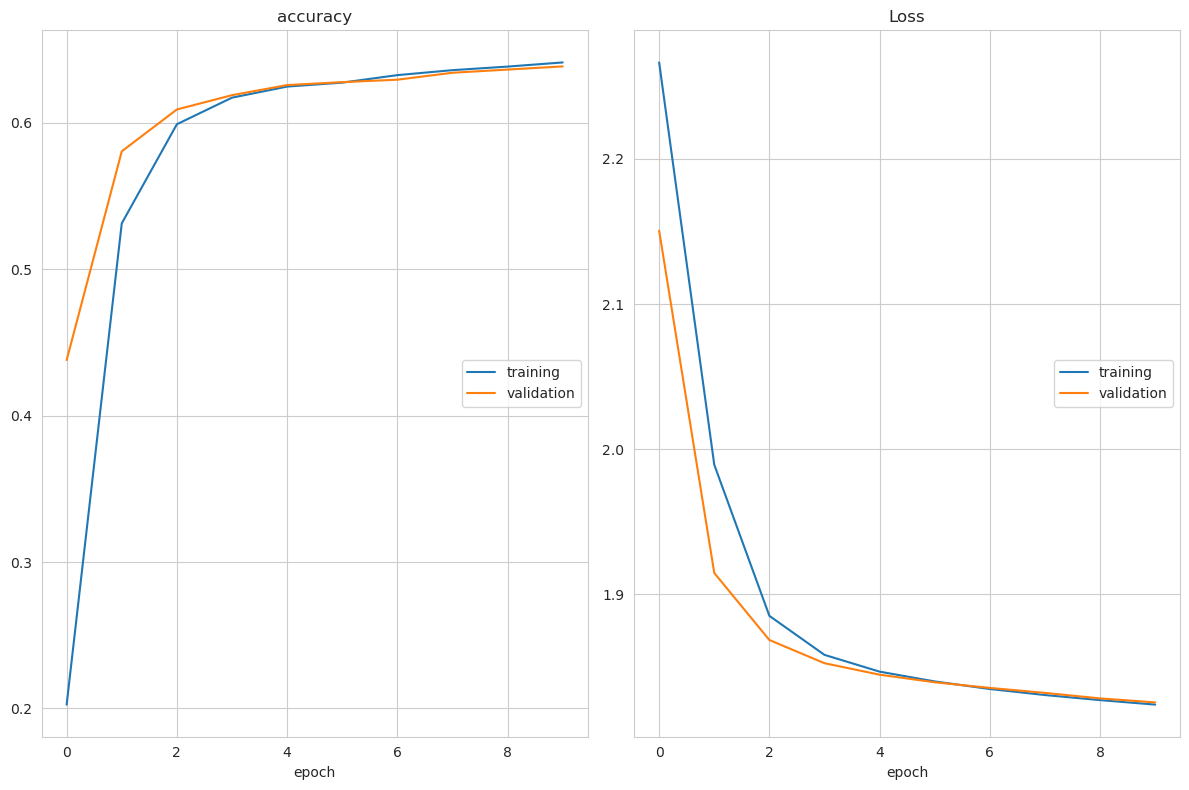

accuracy
	training         	 (min:    0.203, max:    0.641, cur:    0.641)
	validation       	 (min:    0.438, max:    0.639, cur:    0.639)
Loss
	training         	 (min:    1.824, max:    2.266, cur:    1.824)
	validation       	 (min:    1.826, max:    2.151, cur:    1.826)
Tempo gasto: 94.11151493300076 segundos


In [ ]:
######### CNNModel_1_unorm #######
BATCH_SIZE = 128
model = CNNModel_1()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
EPOCHS = 10
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_fashion_unorm_1.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

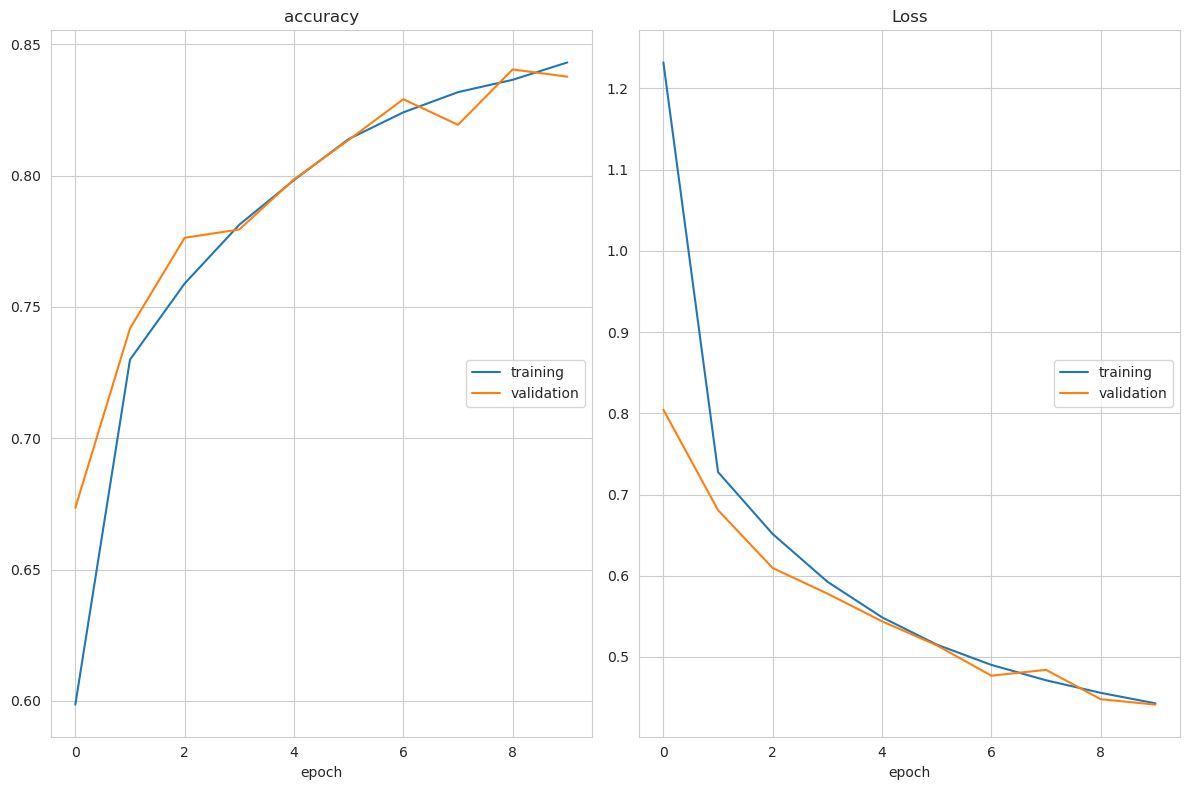

accuracy
	training         	 (min:    0.599, max:    0.843, cur:    0.843)
	validation       	 (min:    0.674, max:    0.840, cur:    0.838)
Loss
	training         	 (min:    0.443, max:    1.232, cur:    0.443)
	validation       	 (min:    0.441, max:    0.804, cur:    0.441)
Tempo gasto: 78.46158156000001 segundos


In [ ]:
######### CNNModel_2_unorm ######
model = CNNModel_2()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
EPOCHS = 10
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_fashion_unorm_2.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

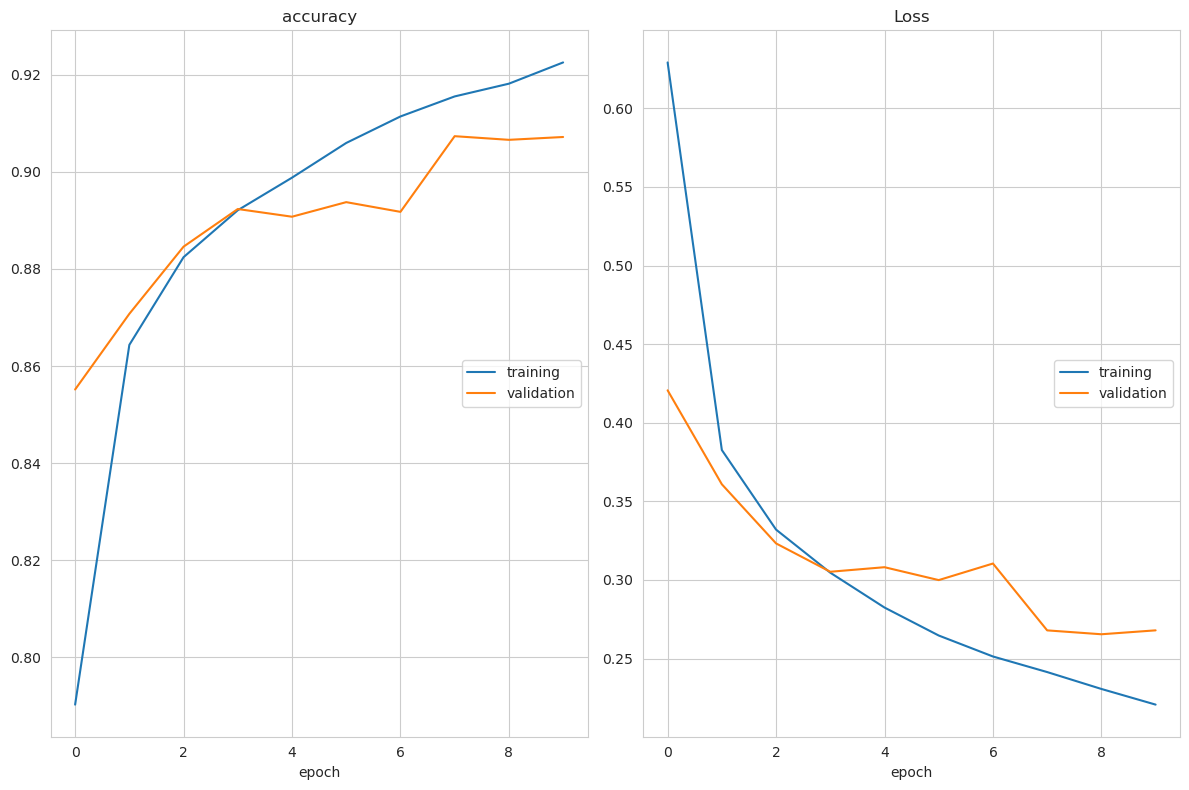

accuracy
	training         	 (min:    0.790, max:    0.923, cur:    0.923)
	validation       	 (min:    0.855, max:    0.907, cur:    0.907)
Loss
	training         	 (min:    0.221, max:    0.629, cur:    0.221)
	validation       	 (min:    0.265, max:    0.421, cur:    0.268)
Tempo gasto: 117.01453758500065 segundos


In [ ]:
######### CNNModel_3_unorm #######
model = CNNModel_3()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
EPOCHS = 10
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_fashion_unorm_3.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

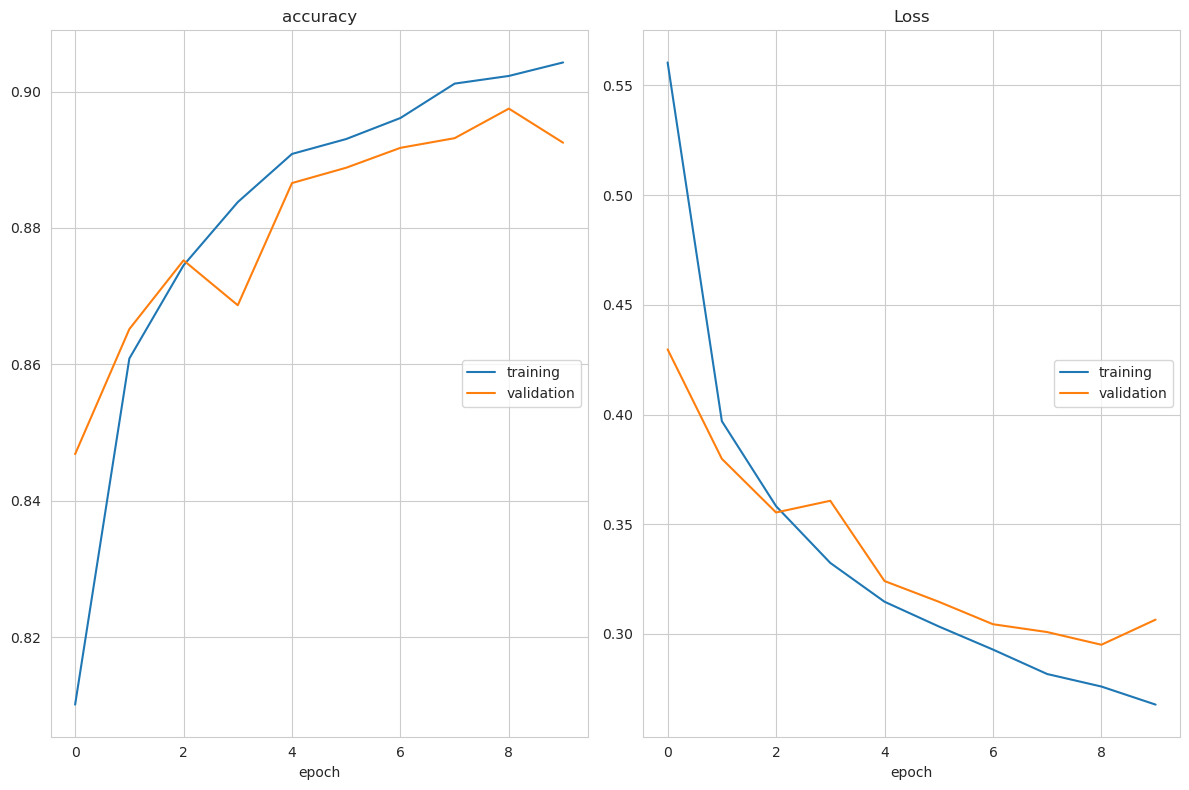

accuracy
	training         	 (min:    0.810, max:    0.904, cur:    0.904)
	validation       	 (min:    0.847, max:    0.897, cur:    0.892)
Loss
	training         	 (min:    0.268, max:    0.560, cur:    0.268)
	validation       	 (min:    0.295, max:    0.430, cur:    0.307)
Tempo gasto: 85.54364167499989 segundos


In [58]:
######### CNNModel_4_unorm ########
model = CNNModel_4()
print(summary(model, input_size=(BATCH_SIZE, 1,28,28), verbose=0))
EPOCHS = 10
LEARNING_RATE = 0.001
criterion = CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=LEARNING_RATE) 
starttime = time.perf_counter()
train_model('CNNModel_fashion_unorm_4.pth', train_dl, val_dl, model, criterion, optimizer)
endtime = time.perf_counter()
print(f"Tempo gasto: {endtime - starttime} segundos")

### Conclusão
De forma geral, os modelos normalizados tendem a apresentar um desempenho superior em termos de precisão e estabilidade. No entanto, essa melhoria vem acompanhada de um aumento no tempo de treino, o que pode representar um compromisso entre eficiência e qualidade dos resultados.

**Eduardo Cunha PG55939**